In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,Model,Input

In [3]:
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Sentiment_Analysis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/gdrive/MyDrive/Sentiment_Analysis/train.csv
/content/gdrive/MyDrive/Sentiment_Analysis/test.csv
/content/gdrive/MyDrive/Sentiment_Analysis/sample_submission.csv


In [4]:
train_dir = "/content/gdrive/MyDrive/Sentiment_Analysis/train.csv"
test_dir = "/content/gdrive/MyDrive/Sentiment_Analysis/test.csv"

In [5]:
train = pd.read_csv(train_dir)
train = train.dropna()
train["sent_codes"] = train["sentiment"].replace({'neutral':2,"positive":1,"negative":0})
print(train.isnull().sum())
print(train.info())
train.head()

textID           0
text             0
selected_text    0
sentiment        0
sent_codes       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
 4   sent_codes     27480 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None


,textID,text,selected_text,sentiment,sent_codes
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,2
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


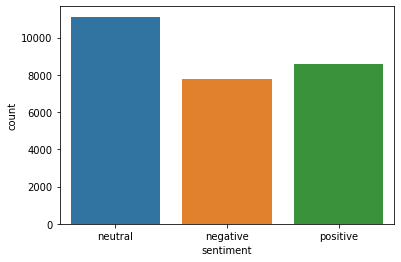

In [6]:
sns.countplot(x= train["sentiment"])

In [7]:
def plot_wordcloud(df):
    words = '' 
    stopwords = set(STOPWORDS)  
    for val in df.values:  
        val = str(val) 
        tokens = val.split()
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = "white", 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(words)                     
    plt.figure(figsize = (24,16), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

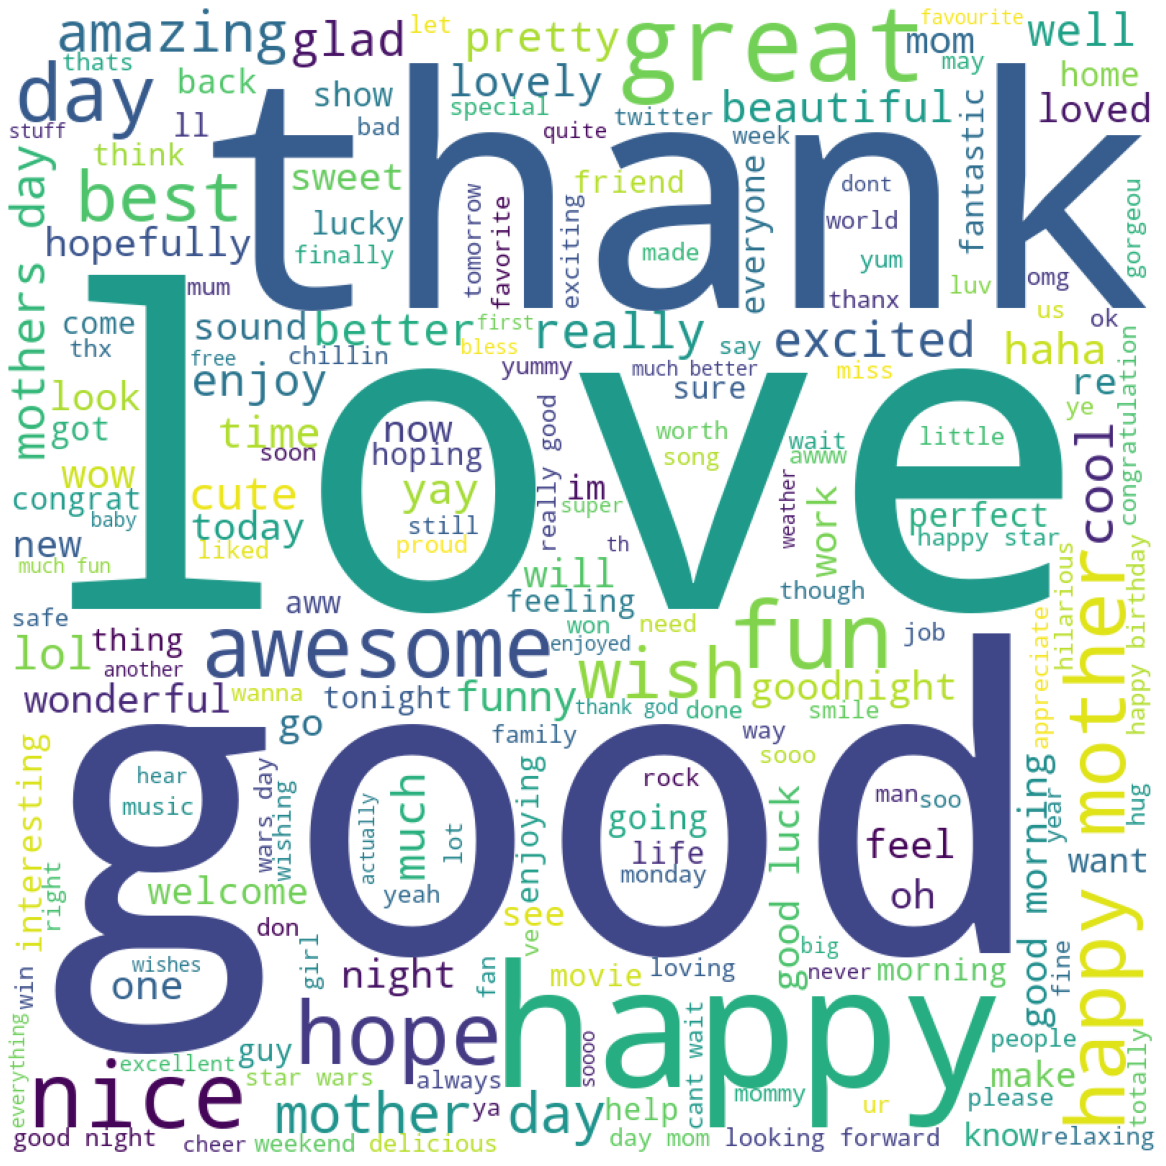

In [8]:
plot_wordcloud(train["selected_text"].where(train["sentiment"]=="positive").dropna())

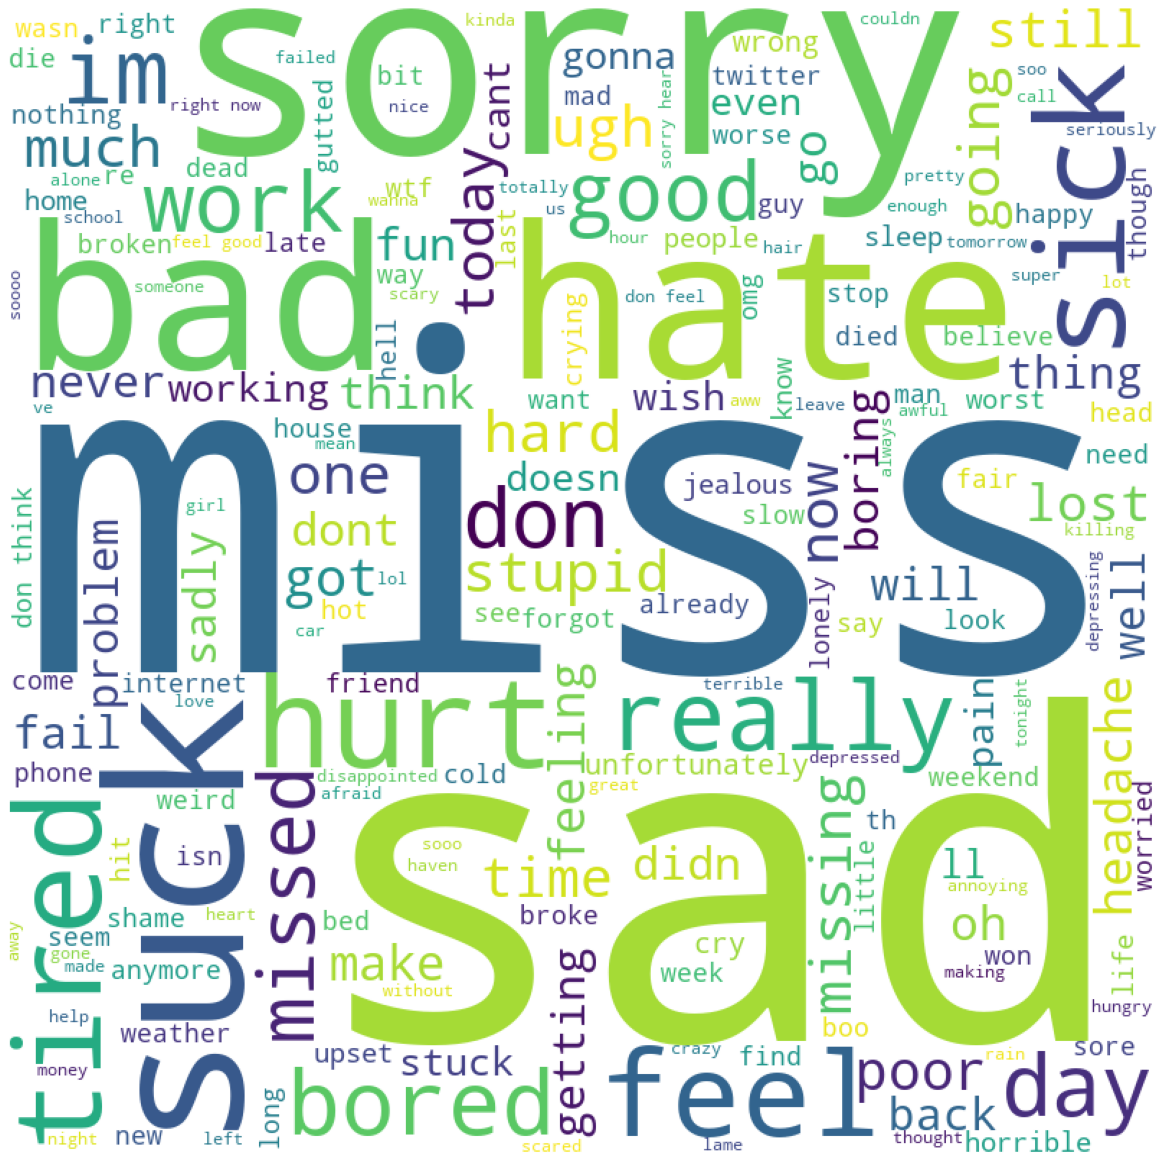

In [9]:
plot_wordcloud(train["selected_text"].where(train["sentiment"]=="negative").dropna())

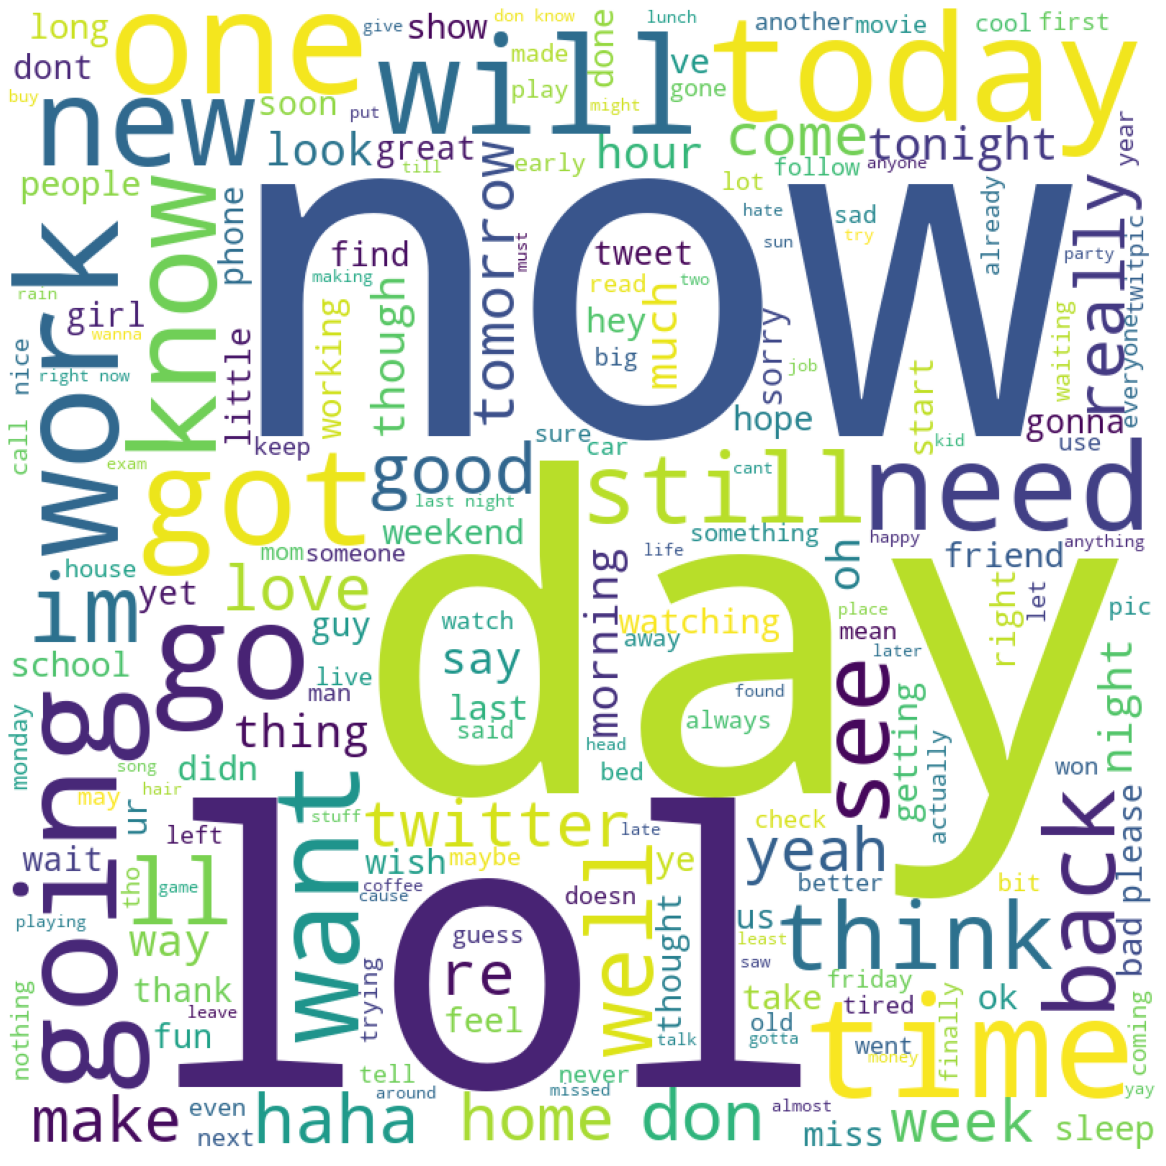

In [10]:
plot_wordcloud(train["selected_text"].where(train["sentiment"]=="neutral").dropna())

In [11]:
filters = " ".join(list(STOPWORDS))

What is Tokenizer?

Ans: It's splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.

What is OOV Token?

Ans: It will replace any unknown words with a token of our choosing. This is better than just throwing away unknown words since it tells our model there was information here.

In [12]:
def tokenize(sentences,tokenizer = None):
    if tokenizer == None:
        tokenizer = Tokenizer(oov_token = "<OOV>")
        tokenizer.fit_on_texts(sentences)
        sequences = tokenizer.texts_to_sequences(sentences)
        padded_sens = pad_sequences(sequences,padding = "post",maxlen=35)
        return padded_sens,tokenizer
    else:
        sequences = tokenizer.texts_to_sequences(sentences)
        padded_sens = pad_sequences(sequences,padding = "post",maxlen=35)
        return padded_sens

In [13]:
X_train = train["selected_text"].values
X_train,tok = tokenize(list(X_train))

train_labels = train["sent_codes"].values

In [14]:
X_train.shape,train_labels.shape

((27480, 35), (27480,))

In [15]:
test = pd.read_csv(test_dir)
test = test.dropna()
test["sent_codes"] = test["sentiment"].replace({'neutral':2,"positive":1,"negative":0})
print(test.isnull().sum())
test.head()

textID        0
text          0
sentiment     0
sent_codes    0
dtype: int64


,textID,text,sentiment,sent_codes
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,2
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,0
3,01082688c6,happy bday!,positive,1
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,1


In [16]:
X_test = test["text"].values
X_test = tokenize(list(X_test),tok)

test_labels = test["sent_codes"].values

In [17]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [21]:
def normal_model():
    model = Sequential()
    model.add(Embedding(27480,35,input_length = 35))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(35,activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(50,activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(25,activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(5,activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(3,activation = "softmax"))
    model.compile(loss = "sparse_categorical_crossentropy",optimizer = tf.keras.optimizers.Adam(lr = 0.001),metrics = ["accuracy"])
    history = model.fit(X_train,train_labels,validation_split = 0.2,shuffle = True,epochs = 15)
    plot_history(history)
    return model

Epoch 1/15
687/687 [==============================] - 9s 13ms/step - loss: 1.0226 - accuracy: 0.4733 - val_loss: 0.6879 - val_accuracy: 0.7238
Epoch 2/15
687/687 [==============================] - 9s 13ms/step - loss: 0.7169 - accuracy: 0.6690 - val_loss: 0.6649 - val_accuracy: 0.7256
Epoch 3/15
687/687 [==============================] - 8s 12ms/step - loss: 0.6378 - accuracy: 0.7269 - val_loss: 0.5835 - val_accuracy: 0.7838
Epoch 4/15
687/687 [==============================] - 8s 12ms/step - loss: 0.5215 - accuracy: 0.8076 - val_loss: 0.5497 - val_accuracy: 0.8130
Epoch 5/15
687/687 [==============================] - 9s 13ms/step - loss: 0.4398 - accuracy: 0.8364 - val_loss: 0.6027 - val_accuracy: 0.7829
Epoch 6/15
687/687 [==============================] - 8s 12ms/step - loss: 0.3827 - accuracy: 0.8574 - val_loss: 0.5724 - val_accuracy: 0.8193
Epoch 7/15
687/687 [==============================] - 8s 12ms/step - loss: 0.3354 - accuracy: 0.8692 - val_loss: 0.5953 - val_accuracy: 0.8124

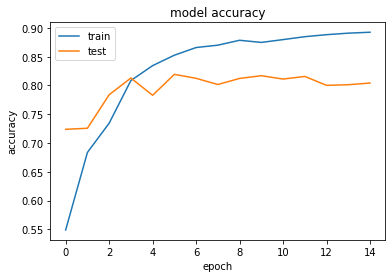

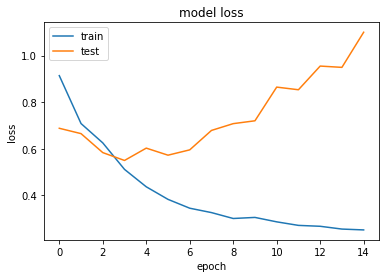

In [22]:
model = normal_model()